# Predicting pectin extraction yield from FTIR ($\textbf{X}_1$) and carbohydrate microarray ($\textbf{X}_2$) data using Multiblock Partial Least Squares regression (MB-PLS)

*The data used in this notebook originates from ref [1]. For further information on the results and the analysis we refer to the paper.*

In this example we use Multiblock Partial Least Squares regression to predict the pectin extraction yield for samples, which were measured on FTIR and Carbohydrate Microarrays during the extraction process. The aim is to establish a prediction model and to investigate how much each measurement block contributes to the prediction of the extraction yield. In addition, MB-PLS gives us the opportunity to interpret the prediction model further, i.e. with respect to how different extraction groups relate to this prediction model. 

We recommend that you check out the FTIR and carbohydrate microarray notebooks prior to working on this notebook. These two notebooks elaborate on modeling pectin yield using both data sets independently.

## Load dependencies and data
If you encounter errors in this section you might need to install some of the python packages stated below (or upgrade). If you re-use and/or re-distribute the data provided please cite the following paper to acknowledge the authorship [1].

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mbpls.data.get_data import load_Intro_Data
from scipy.io import loadmat

In [2]:
data = load_Intro_Data()

Following dataset were loaded as Pandas Dataframes:  dict_keys(['extraction1', 'extraction2', 'extraction3', 'ftir1', 'ftir2', 'ftir3'])


In [3]:
# X1 part
ftir1 = data['ftir1']
ftir2 = data['ftir2']
ftir3 = data['ftir3']
# X2 part
carb1 = data['extraction1']
carb2 = data['extraction2']
carb3 = data['extraction3']

## Merge all dataframes across the sample dimension
To get started with our MB-PLS modeling we merge all dataframes across the sample dimension, meaning that extractions 1, 2 and 3 are merged for FTIR ($\textbf{X}_1$), carbohydrate microarray ($\textbf{X}_2$) and pectin yield ($\textbf{Y}$) data.

In [4]:
x1 = pd.concat((ftir1, ftir2, ftir3))
x2 = pd.concat((carb1, carb2, carb3))
x2.index = x1.index
y = np.array(x2.index)
wavenumbers = x1.columns
x1x2 = pd.concat((x1, x2), axis=1)

## Find number of latent variables using Leave-One-Out Cross Validation
To find the right number of latent variables (LV) we perform cross validation. Scikit-learn makes it easy for us using the cross_val_predict function. We simply re-model the data using different numbers of latent variables and plot the resulting Mean Square Errors (MSE). We pick the number of latent variables where the MSE is minimal to avoid overfitting and to induce as much complexity for our model to obtain most accurate results. Please be aware that the data size is very limited. Therefore, we are risking to overfit. In general it is recommended to perform 5-fold Cross Validation (CV). However, due to the small sample size we use Leave-One-Out CV.

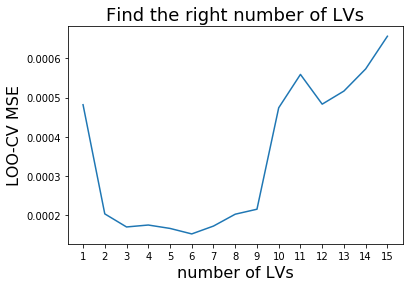

In [5]:
from mbpls.mbpls import MBPLS
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

MSEs = []
for lv in range(15):
    mbpls = MBPLS(n_components=lv+1)
    prediction = cross_val_predict(mbpls, x1x2, y, cv=len(x1x2))
    prediction = pd.DataFrame(prediction)
    MSEs.append(mean_squared_error(prediction, y))

plt.plot(np.arange(1,16), MSEs)
plt.xlabel('number of LVs', fontsize=16)
plt.xticks(np.arange(1,16), np.arange(1,16))
plt.ylabel('LOO-CV MSE', fontsize=16)
plt.title('Find the right number of LVs', fontsize=18);

## Plot resulting calibration curve and evaluate model 
Our plot above indicates that 3 LVs are necessary to establish our MBPLS model. We choose 3 instead of 6 LVs to avoid from overfitting due to the small sample size. We re-model using 3 LVs and plot the resulting calibration to evaluate the mean square prediction error (MSE) of cross validation. 

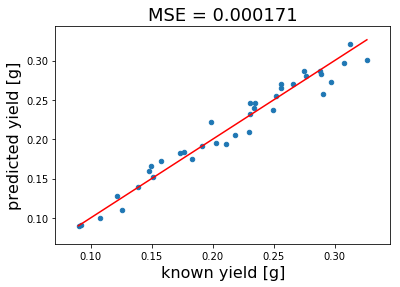

In [6]:
from mbpls.mbpls import MBPLS
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

mbpls = MBPLS(n_components=3)
prediction = cross_val_predict(mbpls, x1x2, y, cv=len(x1x2))
prediction = pd.DataFrame(prediction)
y = pd.DataFrame(y)
prediction = pd.concat((prediction, y), axis=1)
prediction.columns=['predicted yield [g]', 'known yield [g]']
prediction.plot.scatter(x='known yield [g]', y='predicted yield [g]')
plt.plot([prediction.min().min(), prediction.max().max()], 
         [prediction.min().min(), prediction.max().max()], color='red')
plt.ylabel(prediction.columns[0], fontsize=16)
plt.xlabel(prediction.columns[1], fontsize=16)
plt.title('MSE = {:.6f}'.format(mean_squared_error(prediction['known yield [g]'], 
                                    prediction['predicted yield [g]'])), fontsize=18);

## Interpret Multiblock PLS model
Up to now we have done nothing different than prediction modeling. Although we have used MB-PLS the solution is equivalent to PLS, because the feature blocks $\textbf{X}_1$ and $\textbf{X}_2$ were simply concatenated.

Now we want to find out more about how each individual feature block contributes to the actual prediction of pectin yield. To do so we fit an MBPLS estimator as it is done using the Scikit-learn framework and look at the results using the built-in *plot* method

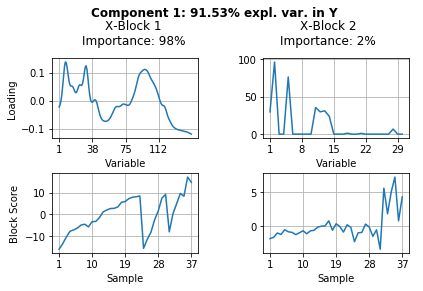

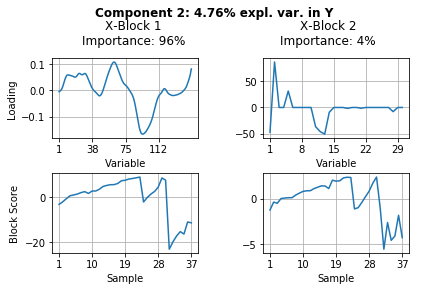

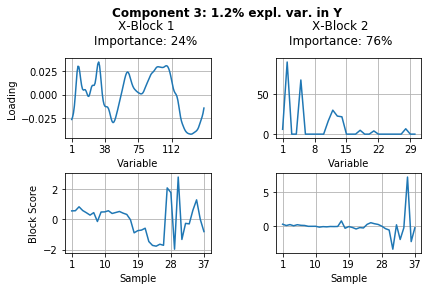

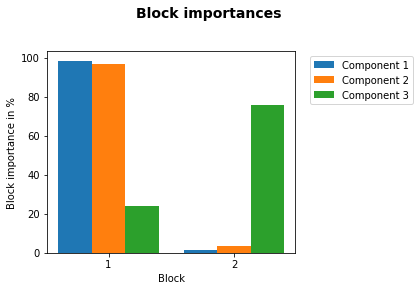

In [7]:
mbpls = MBPLS(n_components=3)
mbpls.fit(X=[x1, x2], Y=y)
# Plot results for the first 3 components (=LVs)
mbpls.plot(num_components=3)

**The results above show a lot of information. Let's summarize what we can see from these results.**

1. Component 1 (= LV1) explains 92.3% of variance in pectin yield ($\textbf{Y}$).
2. For the explanation of these 92.3% block $\textbf{X}_1$ is of 98% and block $\textbf{X}_2$ of 2% importance.
3. Because block $\textbf{X}_1$ is of major importance to explain most of the variance in pectin yield we can go ahead and look further at the block Loadings and scores for this component. We merged our data in the sequence extraction 1 (samples 1-23), extraction 2 (samples 24-30) and extraction 3 (samples 31-37). It turns out that the latent variable loading of component one indicates the FTIR spectral regions which explain differences in pectin yield at different time points during extraction.
4. Component 2 explains 3.9% variance in pectin yield. Once again the FTIR block $\textbf{X}_1$ is of most importance. Looking at the block scores here we can see that it differentiates between enzymatic extractions 1 and 2 and acid extraction 3. The FTIR block loadings looks quite similar although some subtle differences exist due to different chemical matrices during extraction (see below).
5. Component 3 explains only 1.1% of the variance in pectin yield. In this component the carbohydrate microarray data block contained more important information (78% importance). Looking at the block scores one can find out which samples are highly affected by this component - mainly sample 35 and other samples of the acidic extraction 3. The block loading helps to indentify which of the 30 monoclonal antibodies and/or carbohydrate binding modules were responsible for these samples to vary from the rest. 
6. We can conclude that FTIR data is of most importance for prediction of pectin yield. However, the data from the carbohydrate microarrays contribute to the prediction model slightly and can explain minor differences between the different samples. However, these results should be handled carfeully because of the small data size and, hence, insufficient validation of the prediction models.

## Correct block importance for different number of features (variables) in the blocks $\textbf{X}_1$ and $\textbf{X}_2$

The block importance measure depends on the number of features in each block. The FTIR data ($\textbf{X}_1$) contained 143 features, while the carbohydrate microarray data ($\textbf{X}_2$) contained only 30 features. In such cases it might be desriable to correct the block importance for such differences to represent a more realistic result. With our MBPLS package we have built in a corrected measure which yields the corrected block importance for component $k$ and block $i$ such that: 

$BIP_{corr,ik} = BIP_{ik} \cdot (1- \frac{p_i}{p_{total}})$

In the table below BIPs and block size corrected BIPs are presented for our example.

In [8]:
print('The Block Importances [%] in each latent variable are:')
BIP = pd.DataFrame(mbpls.A_.round(2), columns=['LV1', 'LV2', 'LV3'],
                   index=['FTIR', 'Carb Micr Array'])
BIP

The Block Importances [%] in each latent variable are:


,LV1,LV2,LV3
FTIR,0.98,0.96,0.24
Carb Micr Array,0.02,0.04,0.76


In [9]:
print('The corrected Block Importances [%] in each latent variable are:')
BIP_corrected = pd.DataFrame(mbpls.A_corrected_.round(2),
                columns=['LV1', 'LV2', 'LV3'], index=['FTIR', 'Carb Micr Array'])
BIP_corrected

The corrected Block Importances [%] in each latent variable are:


,LV1,LV2,LV3
FTIR,0.92,0.85,0.06
Carb Micr Array,0.08,0.15,0.94


## Explorative analysis - Let's look a bit closer at the ($\textbf{X}_1$) results
As discussed above we can identify certain patterns in the block scores and loadings. Let's go ahead and look a bit closer at these results. Below you can see how the block scores and loadings are extracted from the mbpls model for further analysis. We scatter the block scores of the three latent variables against each other and color them according to extraction type. Extraction 3 was carried using acid. Again, we can see the difference between acidic and enzymatic pectin extracts. This difference is decribed mostly by latent variable 2. If we look at the loading for LV2 we can identify spectral regions which differentiate between acidic and enzymatic extracted pectin. Further analysis of these results is well in line with the chemical interpretation in [1].

The block scores and loadings shown below are the similar to the results from the *plot* method output. However, we simply aim to exemplify how to extract the data from the model and use it for further ad-hoc analysis. To compare these loadings to the actual FTIR block data we have plotted the spectra for all extractions below as well. The spectral greyscale is resembling the pectin yield (dark - lowest; white - highest)

/home/lauve/miniconda3/envs/PLS/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


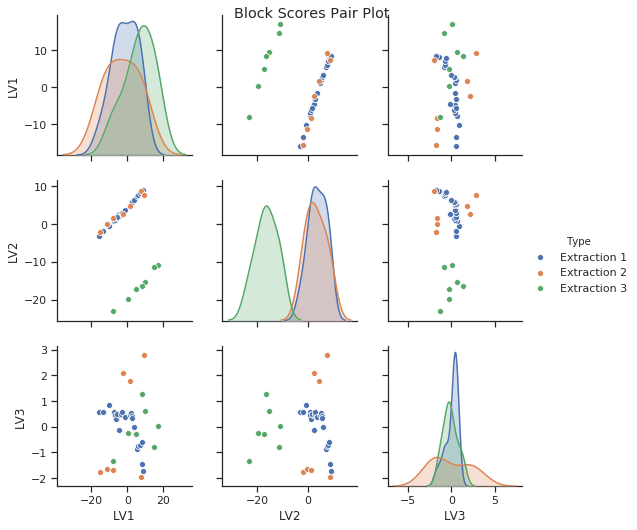

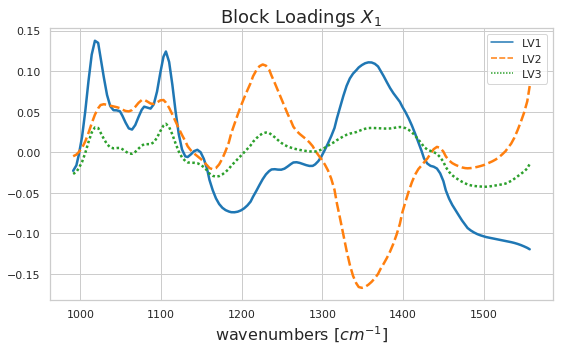

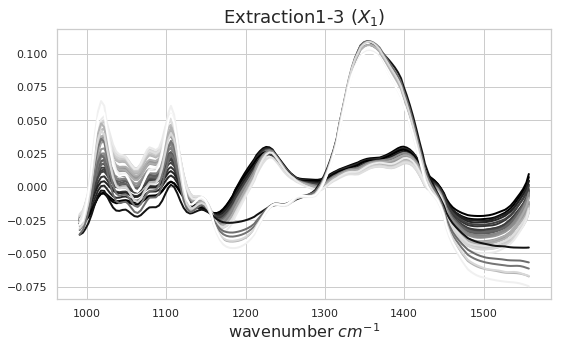

In [10]:
# extract FTIR (X1) block scores from fitted mbpls model
block_scores_x1 = mbpls.T_[0]

# extract FTIR (X1) loadings from fitted mbpls model
block_loadings_x1 = mbpls.P_[0].T

# inverse transform loadings if standardize option was used during fitting 
# (by default) 
block_loadings_x1 = np.hstack([mbpls.x_scalers_[0].inverse_transform(loading)
                            .reshape(-1, 1) for loading in block_loadings_x1])

# Generate a vector which indicates color type for each sample according to 
# extraction 1, 2 and 3
import itertools
colors = [['Extraction 1']*23, ['Extraction 2']*7, ['Extraction 3']*7]
colors = list(itertools.chain(*colors))
colors = pd.DataFrame(colors, columns=['Type'])

# Generate pandas dataframes for easy plotting using seaborn
block_scores_x1 = pd.DataFrame(block_scores_x1, columns=['LV1', 'LV2', 'LV3'])
block_scores_x1 = pd.concat((block_scores_x1, colors), axis=1)
block_loadings_x1 = pd.DataFrame(block_loadings_x1, 
                            columns=['LV1', 'LV2', 'LV3'], index=wavenumbers)

# Plot block scores using pairs plot
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(block_scores_x1, hue="Type")
plt.suptitle('Block Scores Pair Plot')
plt.figure(figsize=(9,5))
sns.set(style="whitegrid")

# Plot FTIR (X1) loadings
sns.lineplot(data=block_loadings_x1, palette="tab10", linewidth=2.5)
plt.title('Block Loadings $X_1$', fontsize=18)
plt.xlabel('wavenumbers [$cm^{-1}$]', fontsize=16);

# Plot function to plot FTIR spectra and color them according extraction 
# yield
def plot_spectra(spectra, ax, name):
    pectin_yield = np.array(spectra.index)
    color_code = (pectin_yield - pectin_yield.min())
    color_code = color_code / color_code.max()
    color_code = color_code[:]
    for spectrum, color in zip(np.array(spectra), color_code):
        ax.plot(wavenumbers, spectrum, color=(color, color, color),
                linewidth=2)
        ax.set_title(name, fontsize=18)
        ax.set_xlabel('wavenumber $cm^{-1}$', fontsize=16)
        plt.tight_layout()

# Plot FTIR spectra in groups of extractions for explorative data 
# analysis
fig, ax = plt.subplots(figsize=(8,5))
plot_spectra(x1, ax, 'Extraction1-3 ($X_1$)')

## Explorative analysis - Let's look closer at the $\textbf{X}_2$ results
We perform the same analysis as above, but this time for the carbohydrate microarray block ($\textbf{X}_2$). Above we said that Block $\textbf{X}_2$ was most important in LV3. When we look at block scores and loadings for LV3 we can see that one sample of extraction 3 performed as an outlier. This sample was could have been measured incorrectly. We can also see that all samples from extraction 1 and 2 (enzymatic) were not really affected by LV3 because they lay all close together and indicate scores around zero in LV3. LV3 was therefore most important for the samples from acidic extraction 3. However, we want to keep in mind that LV3 explains only 1.2% variance in pectin yield.

/home/lauve/miniconda3/envs/PLS/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


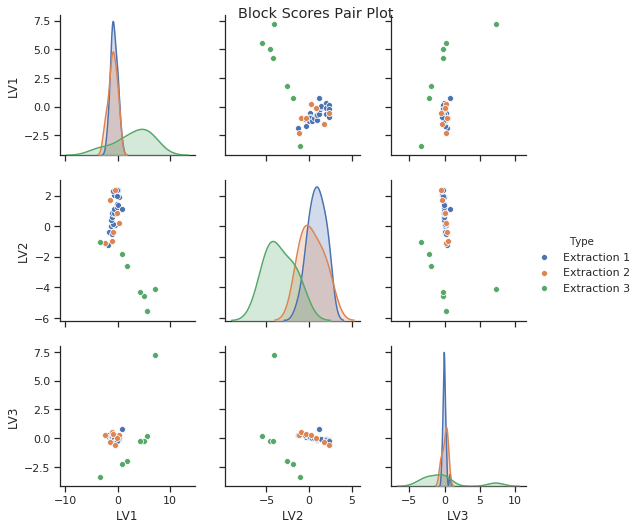

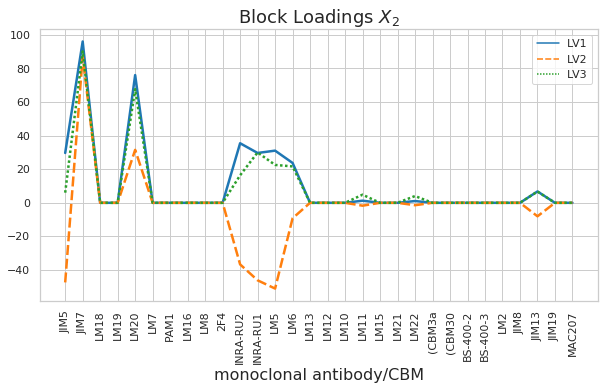

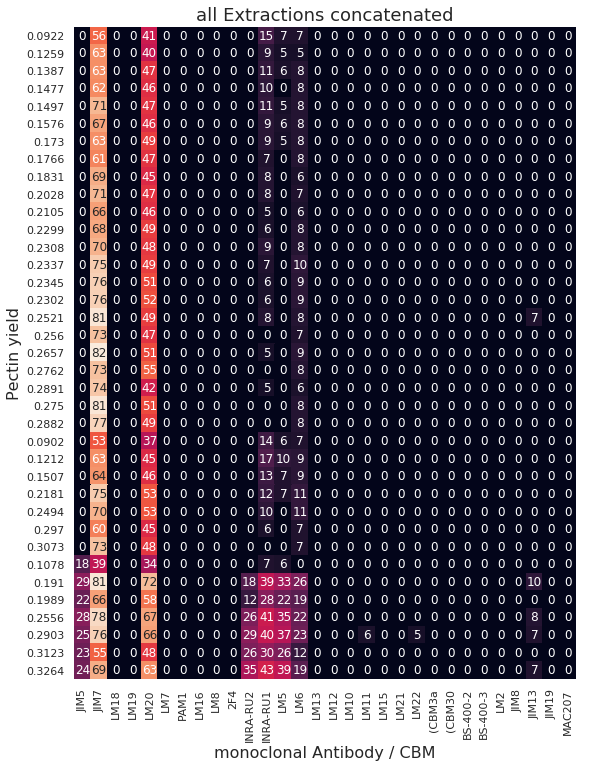

In [11]:
# extract Carb. Micr. Array (X2) block scores from fitted mbpls model
block_scores_x2 = mbpls.T_[1]

# extract Carb. Micr. (X2) loadings from fitted mbpls model
block_loadings_x2 = mbpls.P_[1].T

# inverse transform loadings if standardize option was used during fitting 
# (by default) 
block_loadings_x2 = np.hstack([mbpls.x_scalers_[1].inverse_transform(loading)
                            .reshape(-1, 1) for loading in block_loadings_x2])

# Generate pandas dataframes for easy plotting using seaborn
import itertools
colors = [['Extraction 1']*23, ['Extraction 2']*7, ['Extraction 3']*7]
colors = list(itertools.chain(*colors))
colors = pd.DataFrame(colors, columns=['Type'])

block_scores_x2 = pd.DataFrame(block_scores_x2, columns=['LV1', 'LV2', 'LV3'])
block_scores_x2 = pd.concat((block_scores_x2, colors), axis=1)
block_loadings_x2 = pd.DataFrame(block_loadings_x2, 
                            columns=['LV1', 'LV2', 'LV3'], index=x2.columns)

# Plot block scores using pairs plot
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(block_scores_x2, hue="Type")
plt.suptitle('Block Scores Pair Plot')

# Plot Carb. Micr. Array (X2) loadings
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
sns.lineplot(data=block_loadings_x2, palette="tab10", linewidth=2.5, 
             sort=False)
plt.xticks(rotation=90)
plt.title('Block Loadings $X_2$', fontsize=18)
plt.xlabel('monoclonal antibody/CBM', fontsize=16);

# Plot Carb. Micr. Array data for comparison and exploratory data analysis
plt.figure(figsize=(9,12))
sns.heatmap(x2, annot=True, cbar=False)
plt.title('all Extractions concatenated', fontsize=18)
plt.xlabel('monoclonal Antibody / CBM', fontsize=16)
plt.ylabel('Pectin yield', fontsize=16);

## References

[1] Baum, Andreas, et al. "Prediction of pectin yield and quality by FTIR and carbohydrate microarray analysis." Food and Bioprocess Technology 10.1 (2017): 143-154.